# General overview

-----------------------------------------------------------------------------------------------------------------
The following Jupyter notebook was created in order to automate the process of generating and visualizing forecasts for the macroeconomic indicators using historical time series retrieved using World Bank's Indicators API. Forecast will be generated using ARIMA, SARIMA or SARIMAX model, depending on the suggestion given by the Auto ARIMA library.

# Import libraries and set the display options
------------------------------------------------------------------------------------------------------------------

In [99]:
# General libraries
import json
from datetime import datetime

# Data preprocessing libraries and functions
import numpy as np
import pandas as pd
from retrieval_funcs import create_world_bank_api_url_string, retrieve_url_content
from preprocessing_funcs import convert_bytes_to_unicode, extract_dates_and_values_from_json

# Visualization libraries
import matplotlib.pyplot as plt

# Modelling library
from pmdarima.arima import auto_arima

# Set pandas data display options
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Script parameters
------------------------------------------------------------------------------------------------------------------

Please provide the country and economic indicator codes for which you would like to generate the forecast as well as year up to which it should be done

In [100]:
COUNTRY_CODE = 'afg'
INDICATOR_CODE = 'NY.GDP.MKTP.CN'
PREDICT_UP_TO_YEAR_INCLUSIVE = 2025 

# Retrieve and preprocess data 
------------------------------------------------------------------------------------------------------------------

In [101]:
# Create query string used to retrieve the data using World Bank's Indicators API
query_string = create_world_bank_api_url_string(COUNTRY_CODE, INDICATOR_CODE)

# Retrieve data 
data = retrieve_url_content(query_string)

# Convert retrieved data represented as bytes object to JSON
json_string = convert_bytes_to_unicode(data)
json_content = json.loads(json_string)

# Extract dates and values from JSON
dates, values = extract_dates_and_values_from_json(json_content)

# Create DataFrame object using dates and values
time_series_df = pd.DataFrame.from_dict({"Date": dates,
                                         "Value": values})

# Set index to Date column and change its type to datetime 
time_series_df.set_index('Date', inplace=True)
time_series_df.index = pd.to_datetime(time_series_df.index)

# Sort DataFrame years ascendingly
time_series_df.sort_values(by='Date', inplace=True)

In [102]:
time_series_df.to_csv('data/nygdpmktpcn_afg.csv')

In [ ]:
time_series_df = pd.read_csv('data/nygdpmktpcn_afg.csv')

### Missing values check

Now it's time to check if our time series has any missing values, and if so, deal with them.

There are many approaches to missing data imputation, i.e. filling the missing values with mean or median (might do the job in time independent datasets), using rolling average, training other models on the remaining explanatory variables and using them to predict the values for the missing column (applicable to multivariate datasets and very time consuming) or using some kind of interpolation. In case of the univariate series retrieved from the World Bank, we will stick to some kind of interpolation as suggested in the below article:

<b>https://medium.com/@drnesr/filling-gaps-of-a-time-series-using-python-d4bfddd8c460</b>

Once we are done, we will apply the Auto ARIMA library to help us choose the best forecasting model to the given time series. This will make the script useful for other economic indicators as well.

In [103]:
# If series has any missing values, fill in the gaps using 'time' interpolation
if time_series_df.isnull().sum().sum() > 0:
    time_series_df['InterpolatedValue'] = time_series_df['Value'].interpolate(method='time')
else:
    pass

In [104]:
# Verify the interpolation results by displaying the data
time_series_df.head(55)

,Value,InterpolatedValue
Date,,
1970-01-01,78699896800.000,78699896800.000
1971-01-01,82399903700.000,82399903700.000
1972-01-01,71799996400.000,71799996400.000
1973-01-01,77999996900.000,77999996900.000
1974-01-01,96999997400.000,96999997400.000
1975-01-01,106499997700.000,106499997700.000
1976-01-01,115000000500.000,115000000500.000
1977-01-01,132900003800.000,132900003800.000
1978-01-01,148500004900.000,148500004900.000


In [105]:
# Remove the 'Value' column as we will no longer need it
time_series_df.drop('Value', axis=1, inplace=True)

# Remove last row, if value is missing - we will use model chosen by Auto ARIMA to predict the value for it
LAST_ROW_REMOVED = False

if time_series_df.tail(1).isnull().sum().sum() == 1:
    LAST_ROW_REMOVED = True
    time_series_df.drop(time_series_df.tail(1).index, inplace=True)

# Forecasting with Auto ARIMA
-----------------------------------------------------------------------------------------------------------------

Using Auto ARIMA library will speed up the forecasting process because the data preparation and parameter tuning processes for ARIMA, SARIMA and SARIMAX models end up being really time consuming. Auto ARIMA makes forecast preparation much simpler, because it:

<ul>
    <ul>
        <li> Performs data stationarity checks
        <li> Determines the <b>d</b> value which stands for the number of times the differencing operation has to be applied to the time series to make it stationary
        <li> Handles hyperparameter selection for models, hence saves us from doing this manually by looking at the ACF and PACF plots
        <li> Choses most accurate forecasting model for the given time series
    </ul>
</ul>


### Train the model

In [106]:
model = auto_arima(time_series_df['InterpolatedValue'],
                   start_p=1,
                   start_q=1,
                   max_p=6,
                   max_q=6,
                   max_d=3,
                   max_P=3,
                   max_Q=3,
                   max_iter=100,
                   # Stepwise algo is less likely to over-fit than Grid Search
                   stepwise=True,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True)

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=2457.758, BIC=2465.243, Fit time=0.019 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=2461.246, BIC=2464.988, Fit time=0.004 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=2457.737, BIC=2463.350, Fit time=0.010 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=2455.834, BIC=2461.448, Fit time=0.008 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=2459.287, BIC=2461.158, Fit time=0.003 seconds
Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=2458.204, BIC=2465.689, Fit time=0.013 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=2460.200, BIC=2469.556, Fit time=0.028 seconds
Total fit time: 0.091 seconds


### Forecast future values

In [107]:
# Get current year for the forecast period calculation purposes
curr_year = datetime.now().year

# If last observation had missing value, include it in the forecast horizon
if LAST_ROW_REMOVED:
    num_periods = (PREDICT_UP_TO_YEAR_INCLUSIVE - curr_year) + 2
else:
    num_periods = (PREDICT_UP_TO_YEAR_INCLUSIVE - curr_year) + 1

# Generate forecasts
forecast = model.predict(n_periods=num_periods)

In [109]:
# Get time series beginning year timestamp and convert forecast horizon end year to Timestamp object
time_series_beginning = time_series_df.index[0].year
forecast_end = pd.Timestamp(datetime.strptime(str(PREDICT_UP_TO_YEAR_INCLUSIVE + 1), '%Y'))


# Create DataFrame object storing historical values along with predictions
combined_df = pd.DataFrame({'Date': pd.date_range(start = time_series_beginning,
                                                  end=to_year_date,
                                                  freq='Y'),
                            'Value': time_series_df['InterpolatedValue'].tolist() + list(forecast)})

### Plot full time series and forecast

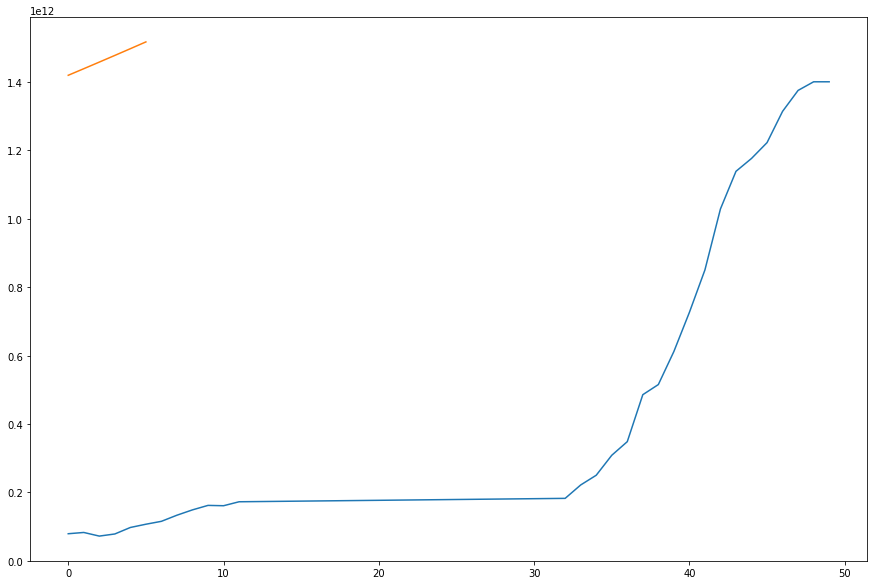

In [19]:
fig = plt.figure(figsize=(15, 10))

plt.plot(combined_df['InterpolatedValue'].values)
plt.plot(forecast)